**BIL 468 Homework**  
Deadline: April 13, 23:59

In this assignment, you are going to train CNN classifiers using Early Stopping on a subset of CIFAR100 dataset. You can include additional methods, layers, options, etc. in order to improve the performance of CNN classifiers. However, **you cannot modify test set**. For example, you can use data augmentation only while training. Also, do not change validation set split method. You are going to train 2 different CNN model:  
- CNN with 4 Conv2D layers (number_convolution_layer = 4)  
- CNN with 6 Conv2D layers (number_convolution_layer = 6)


You are allowed to change any other specifications of the models. For each model:  
- Change student_no with your student ID  
- Set number_convolution_layer to number of Conv2D layers  
- Save the notebook you use to train the model (e.g. CNN_studentID_4.ipynb)  
- Save the final model (e.g. CNN_studentID_4.h5)  
- Run the notebook after training and make sure it works and shows test results correctly

Note that, the notebook saves the best model at the end of the training. If you run the notebook after training, it loads the earlier model and skips the training. If you want to train a different model, you can simply delete or change the name of the earlier saved model. This folder stores an example for a CNN model with 2 Conv2D layers (.h5 and .ipynb files). Upload resulting 2 .h5 files and 2 .ipynb files to UZAK. You are going to be graded on the design details of the models such as performance, originality, architecture, hyperparameter configuration.

For Cifar100 dataset: https://keras.io/api/datasets/cifar100/  
For Keras deep learning library,  
Getting started: https://keras.io/getting_started/intro_to_keras_for_engineers/  
Documentation: https://keras.io/2.16/api/  

In [12]:
# Change parameters for model save name
number_convolution_layer = 6
student_no = 191101024

In [13]:
# Do not change this part
# Sets model save name
model_path = './CNN_' + str(student_no)  + '_' + str(number_convolution_layer) + '.h5'

In [14]:
# Includes libraries
import numpy as np
np.set_printoptions(suppress=True)
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import RandomNormal, GlorotUniform
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.config import list_physical_devices
from tensorflow.keras.layers import LeakyReLU

list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [15]:
# Do not change this part
# Loads data
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(set(list(y_train[:,0])))

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


In [16]:
# Do not change this part
# Removes unused data
relevant_classes = [0, 1, 7, 8, 11, 12, 13, 14, 15, 16]
k = 0
for i in range(20):
    if i in relevant_classes:
        y_train[y_train == i] = k
        y_test[y_test == i] = k
        k = k + 1
    else:
        locations = y_train[:,0] == i
        y_train = np.delete(y_train, locations, axis=0)
        x_train = np.delete(x_train, locations, axis=0)
        locations = y_test[:,0] == i
        y_test = np.delete(y_test, locations, axis=0)
        x_test = np.delete(x_test, locations, axis=0)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(set(list(y_train[:,0])))

(25000, 32, 32, 3) (25000, 1)
(5000, 32, 32, 3) (5000, 1)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [17]:
# Do not change this part
# Creates train, val (validation) and test sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(20000, 32, 32, 3) (20000, 1)
(5000, 32, 32, 3) (5000, 1)
(5000, 32, 32, 3) (5000, 1)


In [18]:
# Do not change this part
# labels are class names
# We have 10 classes
labels = ['aquatic_mammals', 'fish', 'insects', 'large_carnivores',
          'large_omnivores_herbivores', 'medium_mammals',
          'noninsect_invertebrates', 'people', 'reptiles', 'small_mammals']

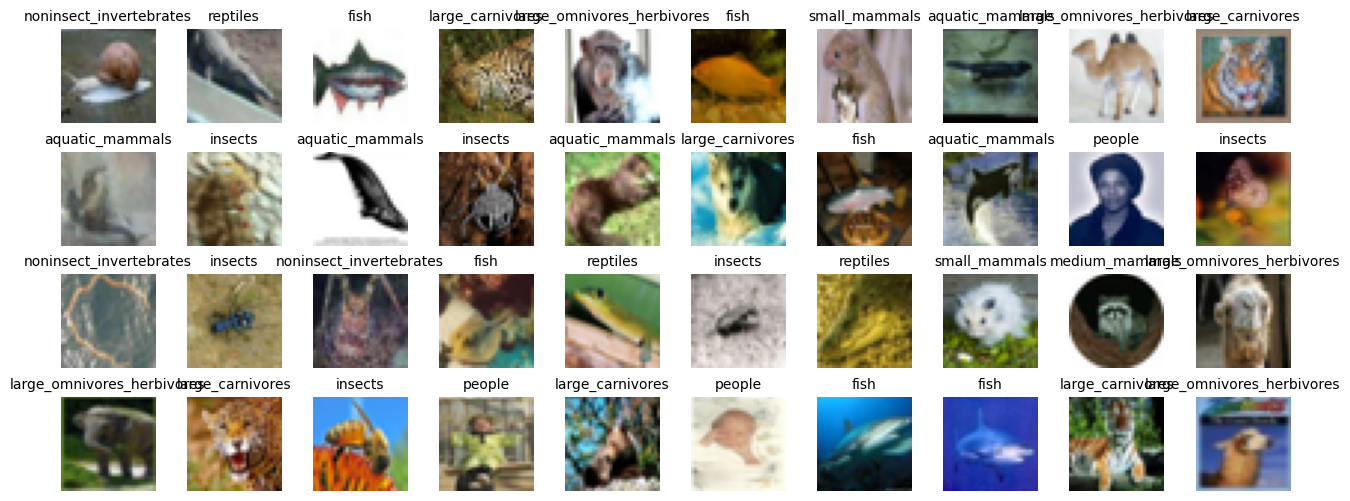

In [19]:
# Displays random images from train set
a, b = 4, 10
fig, axes = plt.subplots(a, b, figsize = (16,6))
axes = axes.ravel()
for i in np.arange(0, a*b):
    index = np.random.randint(x_train.shape[0])
    axes[i].imshow(x_train[index, :, :, :])
    axes[i].set_title(labels[int(y_train[index, 0])], fontsize=10)
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.3)

In [20]:
# Data augmentation for train set
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True)
datagen.fit(x_train)

In [21]:
# CNN model
def CNN(image):
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same')(image)
    x = LeakyReLU(alpha=0.01)(x) 
    x = BatchNormalization()(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x) 
    x = BatchNormalization()(x)
    
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x) 
    x = BatchNormalization()(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x) 
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)

    x = Dense(units=128)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.2)(x)
    x = Dense(units=128)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.2)(x)
    x = Dense(units=10, activation='softmax')(x)
    return x

In [22]:
input_shape = Input((32, 32, 3))
model = Model(input_shape, CNN(input_shape))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

c:\Users\lenovo\anaconda3\envs\your_environment\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,27

 Total params: 653,322 (2.49 MB)

 Trainable params: 652,170 (2.49 MB)

 Non-trainable params: 1,152 (4.50 KB)

None


In [23]:
#model.load_weights(model_path)
print('Training starts...')
model_path = './CNN_' + str(student_no)  + '_' + str(number_convolution_layer) + '.keras'

batch_size = 32
early_stopping = [EarlyStopping(monitor='val_loss', patience=15),
                  ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True)]
history = model.fit(datagen.flow(x_train, y_train_onehot, batch_size=batch_size),
                              epochs=1000,
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_val, y_val_onehot),
                              callbacks=[early_stopping],
                              shuffle=True)
model.load_weights(model_path)

Training starts...
Epoch 1/1000


  1/625 ━━━━━━━━━━━━━━━━━━━━ 45:00 4s/step - accuracy: 0.1250 - loss: 3.0982

c:\Users\lenovo\anaconda3\envs\your_environment\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.1743 - loss: 2.3117 - val_accuracy: 0.2598 - val_loss: 2.0753
Epoch 2/1000


c:\Users\lenovo\anaconda3\envs\your_environment\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2598 - val_loss: 2.0753
Epoch 3/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.2375 - loss: 2.1061 - val_accuracy: 0.2938 - val_loss: 1.9842
Epoch 4/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2938 - val_loss: 1.9842
Epoch 5/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.2669 - loss: 2.0441 - val_accuracy: 0.3182 - val_loss: 1.9308
Epoch 6/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3182 - val_loss: 1.9308
Epoch 7/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.2880 - loss: 2.0050 - val_accuracy: 0.3036 - val_loss: 1.9565
Epoch 8/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3036 - val_loss: 1.9565
Epoch 9/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accurac

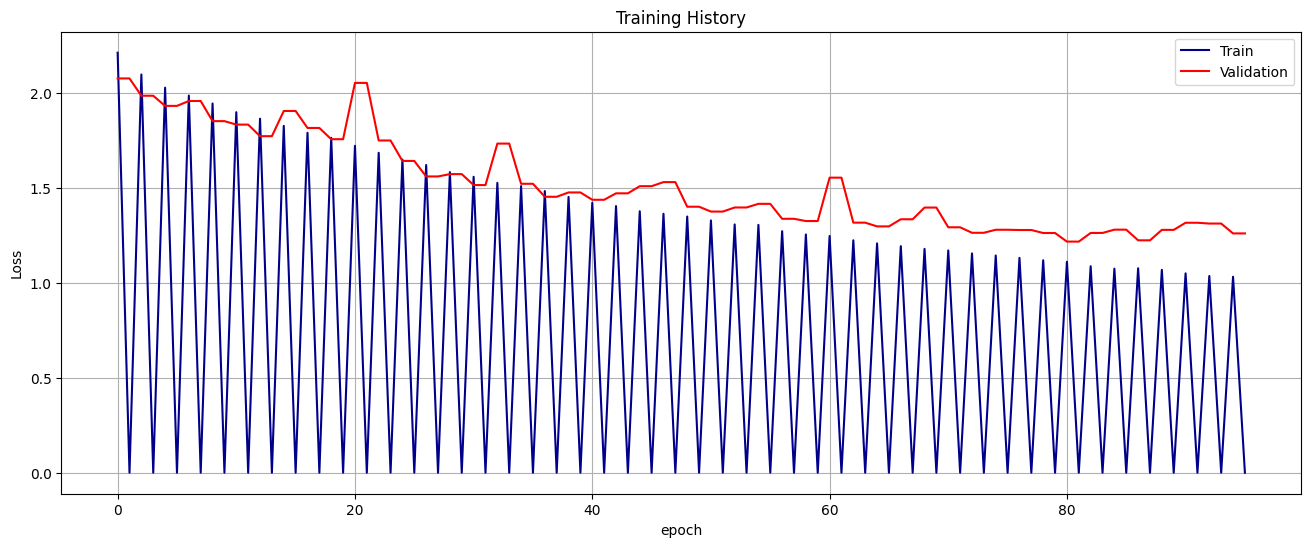

In [29]:

# Plots training history
try:
    plt.subplots(figsize=(16,6))
    plt.plot(history.history['loss'], color='darkblue', linewidth=1.5, label='Train')
    plt.plot(history.history['val_loss'], color='red', linewidth=1.5, label='Validation')
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
except:
    pass

In [30]:
# Test performance
probs_test = model.predict(x_test)
preds_test = np.argmax(probs_test, axis=1)
print('Accuracy: {:.4}'.format(accuracy_score(y_test, preds_test)))
print('F1-score: {:.4}'.format(f1_score(y_test, preds_test, average='weighted')))
print(classification_report(y_test, preds_test, target_names=labels))

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Accuracy: 0.597
F1-score: 0.594
                            precision    recall  f1-score   support

           aquatic_mammals       0.59      0.55      0.57       500
                      fish       0.76      0.60      0.67       500
                   insects       0.68      0.76      0.72       500
          large_carnivores       0.55      0.65      0.59       500
large_omnivores_herbivores       0.62      0.61      0.61       500
            medium_mammals       0.58      0.47      0.52       500
   noninsect_invertebrates       0.46      0.62      0.53       500
                    people       0.73      0.84      0.78       500
                  reptiles       0.47      0.44      0.46       500
             small_mammals       0.58      0.42      0.49       500

                  accuracy                           0.60      5000
                 macro avg       0.60      0.60      0.59      5000
              weighted avg       0.60   

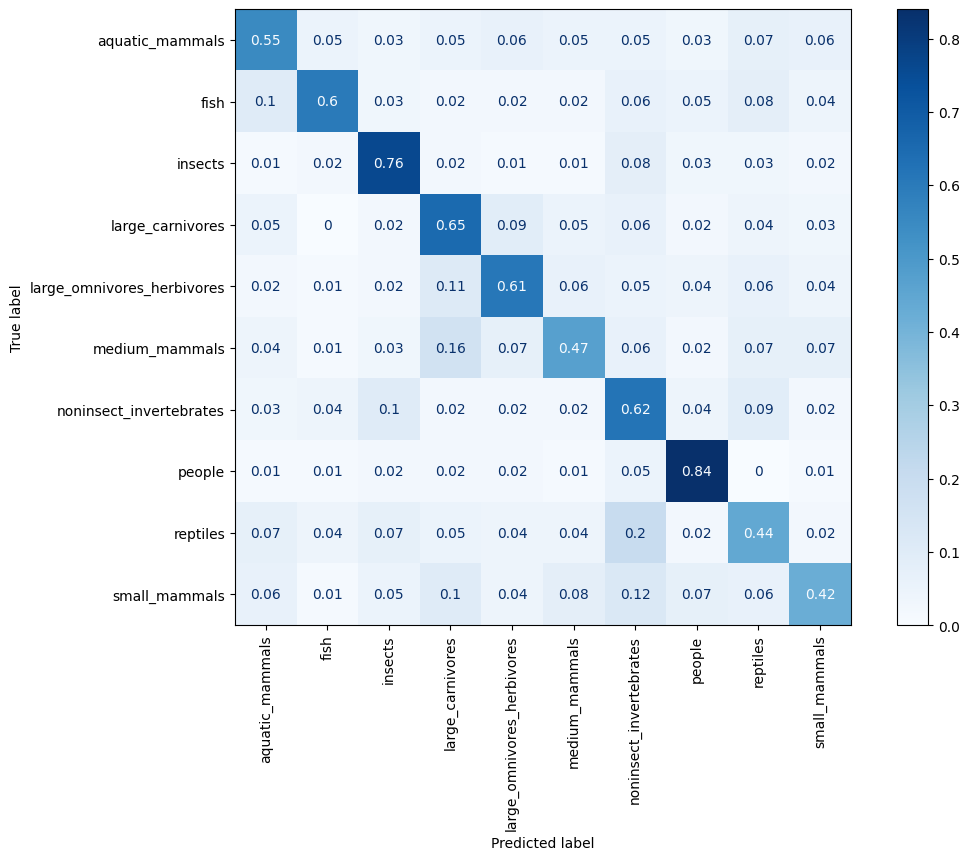

In [26]:
# Confusion matrix
CM = np.round(confusion_matrix(y_test, preds_test, normalize='true'), 2)
CMD = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=labels)
fig, ax = plt.subplots(figsize=(12,8))
CMD.plot(xticks_rotation='vertical', ax=ax, cmap='Blues')
plt.show()

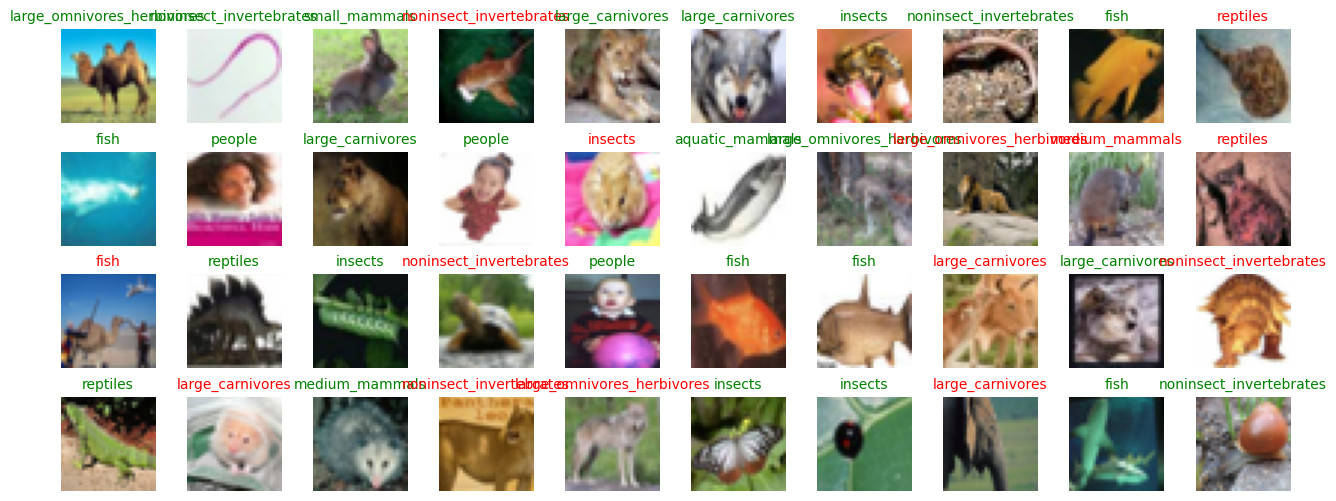

In [27]:
# Displays random image predictions from test set
a, b = 4, 10
fig, axes = plt.subplots(a, b, figsize = (16,6))
axes = axes.ravel()
for i in np.arange(0, a*b):
    index = np.random.randint(x_test.shape[0])
    axes[i].imshow(x_test[index, :, :, :])
    if preds_test[index] == int(y_test[index, 0]):
        axes[i].set_title(labels[preds_test[index]], fontsize=10, color='green')
    else:
        axes[i].set_title(labels[preds_test[index]], fontsize=10, color='red')
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.3)